ECML-PKDD 2020 Hands-on Tutorial

*What and How of Machine Learning Transparency*:  
Building Bespoke Explainability Tools with Interoperable Algorithmic Components

<https://events.fat-forensics.org/>

Authors: Kacper Sokol <k.sokol@bristol.ac.uk> and
         Alex Hepburn <ah13558@bristol.ac.uk>  
Licence: new BSD

---

---

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fat-forensics/events/blob/master/)
[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fat-forensics/events/master)

First, we need to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
LIBRARY_URL = ('https://raw.githubusercontent.com/fat-forensics/events/master/'
               'resources/2020_ecml-pkdd/notebooks/fatf_ecml.py')

try:
    import google.colab
    !wget $LIBRARY_URL -O fatf_ecml.py
except ImportError:
    pass

import fatf_ecml

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display

%matplotlib inline

In [3]:
fatf_ecml.initialise_colab()

Not in Colab; nothing to do.


In [4]:
import fatf

In [9]:
import fatf.utils.data.discretisation as fatf_discretisation
import fatf.utils.data.transformation as fatf_transformation

import fatf.utils.data.augmentation as fatf_augmentation

20-Sep-01 16:06:17 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [29]:
import sklearn.tree

# Binary Interpretable Representations for Tabular Data #

In search of a binary interpretable representation for tabular data.

## Toy Example -- Two Moons ##

### Loading the Data ###

In [5]:
moons_X, moons_X_test, moons_y, moons_y_test = fatf_ecml.generate_2d_moons(
    random_seed=42)

20-Sep-01 16:05:31 fatf         INFO     Seeding RNGs using the input parameter.
20-Sep-01 16:05:31 fatf         INFO     Seeding RNGs with 42.


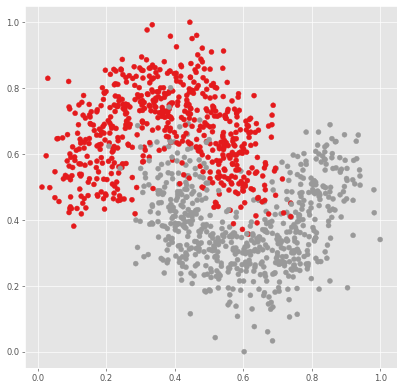

In [6]:
# Plot data
plt.figure(figsize=(8, 8), dpi=60)
plt.scatter(moons_X[:, 0], moons_X[:, 1], cmap=plt.cm.Set1, c=moons_y)

### Selecting an Instance to be Explained ###

In [7]:
instance_m_index = 42
instance_m = moons_X_test[instance_m_index, :]
instance_m_label = moons_y_test[instance_m_index]

print('Instance *m*:')
display(instance_m)
display(instance_m_label)

Instance *m*:


array([0.30886033, 0.73748125])

0

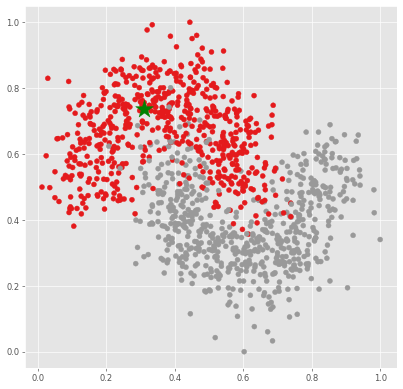

In [8]:
# Plot data
plt.figure(figsize=(8, 8), dpi=60)
plt.scatter(moons_X[:, 0], moons_X[:, 1], cmap=plt.cm.Set1, c=moons_y)

# Plot explained instance
plt.scatter(instance_m[0], instance_m[1], c='green', marker='*', s=500)

### Quartile-based Interpretable Representation ###

This interpretable representation is built in two steps:
* discretising each *numerical* feature into 4 bins based on
  data quartiles; and
* encoding the hyper-rectangles built in the previous step
  in a binary in/out representation that depends on the
  location of the explained instance.

Let's go through these steps one by one.

Before building a binary interpretable representation, we generate a sample of
250 data points in the neighbourhood of the explained instance (*m*), which are
required for building a surrogate -- see the *data sampling* notebook for more
details.

In [10]:
augmenter_moons = fatf_augmentation.NormalSampling(moons_X)

In [11]:
sample_moons_m = augmenter_moons.sample(
    instance_m, samples_number=250)

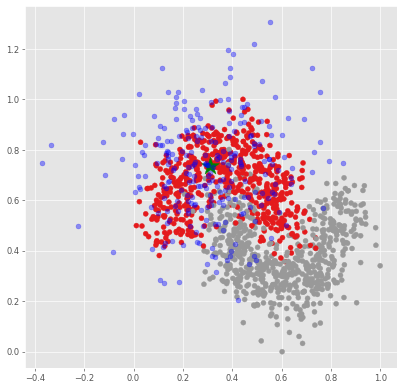

In [12]:
# Plot data
plt.figure(figsize=(8, 8), dpi=60)
plt.scatter(moons_X[:, 0], moons_X[:, 1], cmap=plt.cm.Set1, c=moons_y)

# Plot explained instance
plt.scatter(instance_m[0], instance_m[1], c='green', marker='*', s=500)

# Plot augmented data
plt.scatter(sample_moons_m[:, 0], sample_moons_m[:, 1], c='blue', alpha=.4)

#### Step 1: Quartile Discretisation ####

In [13]:
q_discretiser_moons = fatf_discretisation.QuartileDiscretiser(moons_X)

In [14]:
moons_X_discrete = q_discretiser_moons.discretise(moons_X)
moons_X_test_discrete = q_discretiser_moons.discretise(moons_X_test)

sample_moons_m_discrete = q_discretiser_moons.discretise(sample_moons_m)

Let's print out and visualise our quartiles.

In [15]:
q_discretiser_moons.feature_bin_boundaries

{0: array([0.35216058, 0.48959027, 0.64267622]),
 1: array([0.36564816, 0.52390789, 0.67212217])}

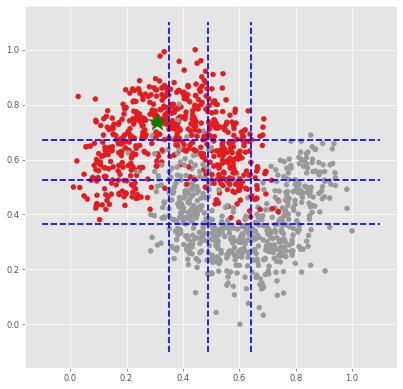

In [16]:
# Plot data
plt.figure(figsize=(8, 8), dpi=60)
plt.scatter(moons_X[:, 0], moons_X[:, 1], cmap=plt.cm.Set1, c=moons_y)

# Plot explained instance
plt.scatter(instance_m[0], instance_m[1], c='green', marker='*', s=500)

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    plt.plot([i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    plt.plot([-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

We can also get a discretised version of the explained instance *m*.

In [17]:
instance_m_discrete = q_discretiser_moons.discretise(instance_m)

display(instance_m_discrete)

array([0, 3], dtype=int8)

The faithfulness of this discretisation (with respect to the labels of the
training data) seems to be really good.
In this particular case, it is possible to assess this property by means of
visual inspection since the data set is two-dimensional.
However, when dealing with a higher number of dimensions, we need a proxy to
measure the quality of our discretisation.
To this end, we propose two metrics that can be applied to each individual
hyper-rectangle:

* **Gini Index** for *crisp* classification tasks; and
* **Mean Squared Error** for *probabilistic* classification and regression.

Let's count the labels and measure *Gini Index* of the hyper-rectangle
enclosing our explained instance *m*.

In [18]:
moons_X_hr_m_indices = fatf_ecml.get_hyperrectangle_indices(
    moons_X_discrete, instance_m_discrete)

moons_X_hr_m = moons_X_discrete[moons_X_hr_m_indices, :]
moons_y_hr_m = moons_y[moons_X_hr_m_indices]

In [19]:
np.unique(moons_y_hr_m, return_counts=True)

(array([0, 1]), array([134,   1]))

In [20]:
fatf_ecml.gini_index(moons_y_hr_m)

0.014705075445816198

It seems to be fairly pure, which agrees with the label count and our
intuition based on the visualisations.

Now, we need to do the same for all of the hyper-rectangles.
Since some partitions may hold a relatively small number of data points, e.g.,
the top-right and bottom-left hyper-rectangles, this observation needs to be
taken into account to avoid biasing our metric.
To this end, we employ an average **weighted** by the number of instances in
each partition.

In [21]:
fatf_ecml.weighted_purity(moons_X_discrete, moons_y, 'gini')

0.13028591315141477

This number is consistent with what we have seen so far -- it is a pretty good
discretisation.

Next, we move on to **binarisation** -- creating a binary interpretable
representation with respect to the explained instance.

#### Step 2: Binarisation ####

So far so good.
However, discretisation is not the representation used for fitting a local surrogate model.
While Step 1 is universally applicable to any instance we may wish to explain,
Step 2 is specific to the explained data point.
To be more precise, it is specific to each unique *hyper-rectangle*, i.e.,
a partition of the feature space resulting from the discretisation step.

---

The binarisation procedure is *XNOR* -- 1 if the same, 0 if different --
applied between the discrete representation of a data sample and the explained
data point.
Therefore, for each dimension -- *x* and *y* axes independently in our example --
it encodes whether a given partition of this feature is the one holding the
explained data point.

Before processing the data, let's see a visualisation of this step for our
explained instance *m*.

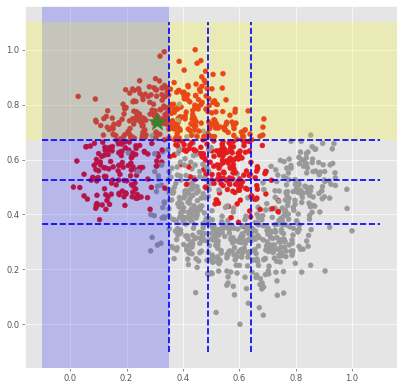

In [22]:
# Plot data
plt.figure(figsize=(8, 8), dpi=60)
plt.scatter(moons_X[:, 0], moons_X[:, 1], cmap=plt.cm.Set1, c=moons_y)

# Plot explained instance
plt.scatter(instance_m[0], instance_m[1], c='green', marker='*', s=500)

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    plt.plot([i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    plt.plot([-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

# Plot binarisation of the x-axis
hyper_rectangle_m_x = instance_m_discrete[0]
if 0 < hyper_rectangle_m_x < 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 0:
    hyper_rectangle_m_x_min = -0.1
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = 1.1
plt.axvspan(hyper_rectangle_m_x_min, hyper_rectangle_m_x_max,
            facecolor='blue', alpha=0.2)

# Plot binarisation of the y-axis
hyper_rectangle_m_y = instance_m_discrete[1]
if 0 < hyper_rectangle_m_y < 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 0:
    hyper_rectangle_m_y_min = -0.1
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = 1.1
plt.axhspan(hyper_rectangle_m_y_min, hyper_rectangle_m_y_max,
            facecolor='yellow', alpha=0.2)

Since we have two dimensions:

* **blue** encodes the x-axis partition that holds the explained instance; and
* **yellow** encodes the y-axis partition that holds the explained instance.

This *binarisation* results in four distinct encodings in the
*binary interpretable representation*:

* **blue & yellow** -- (1, 1);
* **blue & not yellow** -- (1, 0);
* **not blue & yellow** -- (0, 1); and
* **not blue & not yellow** -- (0, 0).

---

Now, let's compute this representation and visualise it with different markers.

In [23]:
moons_X_m_binary = fatf_transformation.dataset_row_masking(
    moons_X_discrete, instance_m_discrete)

instance_m_binary = np.ones_like(instance_m_discrete, dtype=np.int8)

display(instance_m_binary)

array([1, 1], dtype=int8)

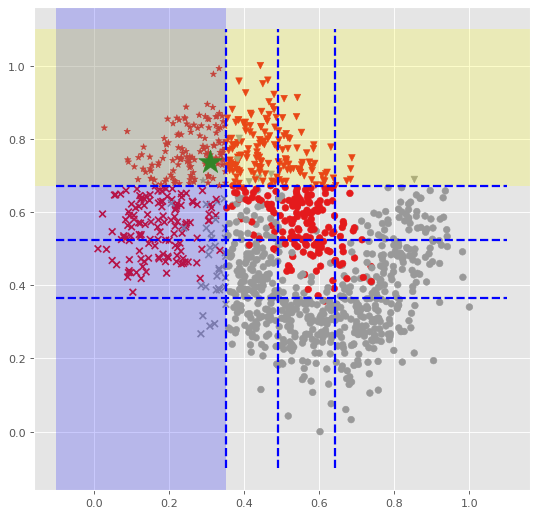

In [24]:
plt.figure(figsize=(8, 8), dpi=80)

# Plot data using a unique marker for each binary encoding
moons_unique_binary = np.unique(moons_X_m_binary, axis=0)
for rep in moons_unique_binary:
    indices = fatf_ecml.get_hyperrectangle_indices(
        moons_X_m_binary, rep)

    if np.array_equal(rep, [1, 1]):
        marker = '*'
    elif np.array_equal(rep, [1, 0]):
        marker = 'x'
    elif np.array_equal(rep, [0, 1]):
        marker = 'v'
    else:
        marker = 'o'

    plt.scatter(moons_X[indices, 0], moons_X[indices, 1],
                cmap=plt.cm.Set1, c=moons_y[indices], marker=marker)

# Plot explained instance
plt.scatter(instance_m[0], instance_m[1], c='green', marker='*', s=500)

# Plot x-axis quartiles
x_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(0)
for i in x_quartiles_m:
    plt.plot([i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')

# Plot y-axis quartiles
y_quartiles_m = q_discretiser_moons.feature_bin_boundaries.get(1)
for i in y_quartiles_m:
    plt.plot([-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

# Plot binarisation of the x-axis
hyper_rectangle_m_x = instance_m_discrete[0]
if 0 < hyper_rectangle_m_x < 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 0:
    hyper_rectangle_m_x_min = -0.1
    hyper_rectangle_m_x_max = x_quartiles_m[hyper_rectangle_m_x]
elif hyper_rectangle_m_x == 3:
    hyper_rectangle_m_x_min = x_quartiles_m[hyper_rectangle_m_x - 1]
    hyper_rectangle_m_x_max = 1.1
plt.axvspan(hyper_rectangle_m_x_min, hyper_rectangle_m_x_max,
            facecolor='blue', alpha=0.2)

# Plot binarisation of the y-axis
hyper_rectangle_m_y = instance_m_discrete[1]
if 0 < hyper_rectangle_m_y < 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 0:
    hyper_rectangle_m_y_min = -0.1
    hyper_rectangle_m_y_max = y_quartiles_m[hyper_rectangle_m_y]
elif hyper_rectangle_m_y == 3:
    hyper_rectangle_m_y_min = y_quartiles_m[hyper_rectangle_m_y - 1]
    hyper_rectangle_m_y_max = 1.1
plt.axhspan(hyper_rectangle_m_y_min, hyper_rectangle_m_y_max,
            facecolor='yellow', alpha=0.2)

Everything is as expected.

---

Having seen this visualisation, you may have noticed an undesired consequence
of applying the bianrisation step -- it partially breaks the purity of
our discretisation.
Since this step combines multiple hyper-rectangles that may hold different
classes, the purity of the binary representation may suffer despite having
nearly perfect discretisation.
This is especially visible for the (0, 0) encoding in the binary interpretable
representation -- the regions without any shading, i.e., the
bottom-right partitions, which mix red and grey instances.

A complementary observation is the *unnecessity* of splitting each numerical
feature into more than *three* partitions.
Two sections are enough for bordering partitions -- see the x-axis and y-axis
splits -- and three are required when the explained instance is "sandwiched"
between two partitions.

Finally, let's see how these visual observations translate into our proxy
metrics for split purity.

In [25]:
moons_X_binary_m_indices = fatf_ecml.get_hyperrectangle_indices(
    moons_X_m_binary, instance_m_binary)

moons_X_binary_m = moons_X_discrete[moons_X_binary_m_indices, :]
moons_y_binary_m = moons_y[moons_X_binary_m_indices]

In [26]:
np.unique(moons_y_binary_m, return_counts=True)

(array([0, 1]), array([134,   1]))

In [27]:
fatf_ecml.gini_index(moons_y_binary_m)

0.014705075445816198

Unsurprisingly, the label count and purity of the explained hyper-rectangle
have not changed -- it was not (and never is) merged with any other partition
unlike the remaining hyper-rectangles.

Let's compute the overall purity then.

In [28]:
fatf_ecml.weighted_purity(moons_X_m_binary, moons_y, 'gini')

0.26466978171740074

As expected, the impurity has seen a considerable jump.

### Tree-based Interpretable Representation ###

Let's try something different -- generating an interpretable representation
based on a feature space partition created by a decision tree.
Conceptually, such an approach has the advantage over quartile-based
discretisation since it has access to data labels in the selected region
(either ground truth or black-box predictions).
To check our intuition, we can calculate purity of this discretisation and
compare it visually to our previous results.

#### Tree-based Discretisation ####
Since each feature was split into 4 bins with quartile-based discretisation,
this discrete space had the cardinality of $4^d$, where $d$ is the number of
features in the original representation.
Here, we limit the number of tree leaves to $4^2 = 16$ to give the tree
comparable expressiveness.

In [30]:
tree_discretiser_moons = sklearn.tree.DecisionTreeClassifier(
    random_state=42, max_leaf_nodes=16)
tree_discretiser_moons.fit(moons_X, moons_y)

DecisionTreeClassifier(max_leaf_nodes=16, random_state=42)

Let's plot the decision tree splits.

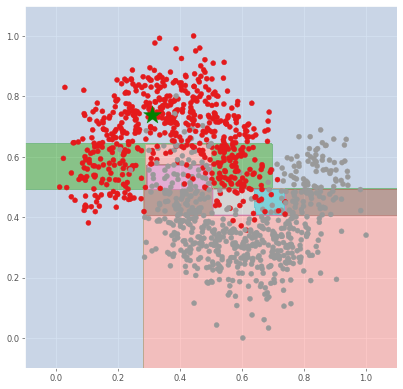

In [31]:
plt.figure(figsize=(8, 8), dpi=60)

# Compute the decision boundary of the tree
x_y_step = 0.005
x_min, x_max = -0.1, 1.1
y_min, y_max = -0.1, 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, x_y_step),
                     np.arange(y_min, y_max, x_y_step))

Z = tree_discretiser_moons.apply(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
Z_norm = np.zeros_like(Z)
for i, v in enumerate(np.unique(Z)):
    mask = (Z == v)
    Z_norm[mask] = i

# Plot the boundary
plt.contourf(xx, yy, Z_norm, cmap=plt.cm.tab20, alpha=0.5)

# Plot data
plt.scatter(moons_X[:, 0], moons_X[:, 1], cmap=plt.cm.Set1, c=moons_y)

# Plot explained instance
plt.scatter(instance_m[0], instance_m[1], c='green', marker='*', s=500)

Also, let's compute the purity of this discretisation.

> **Note that we are using the `apply` method of our tree classifier -- it
  returns the leaf ID of each instance, i.e., its hyper-rectangle ID.**

We start with purity of the partition assigned to the explained instance.

In [32]:
moons_X_discrete_tree = tree_discretiser_moons.apply(moons_X)

In [33]:
instance_m_discrete_tree = tree_discretiser_moons.apply([instance_m])

moons_X_tree_m_indices = fatf_ecml.get_hyperrectangle_indices(
    moons_X_discrete_tree, instance_m_discrete_tree)

moons_y_tree_m = moons_y[moons_X_tree_m_indices]

fatf_ecml.gini_index(moons_y_tree_m)

0.04032871972318343

It is slightly worse than the one achieved with quartiles (0.015).

---

Now, let's compute purity of the whole discretisation.

In [34]:
fatf_ecml.weighted_purity(moons_X_discrete_tree, moons_y, 'gini')

0.06319989994928496

Which gives a better result than quartiles (0.13).

#### Binarisation ####
Binarisation of the tree-based discretisation is not a well-defined concept.
The best we can do is one-hot encode each tree partitioni, i.e., hyper-rectangle.
Such a representation, however, would have higher expressiveness than
binarised quartile-based discretisation, hence the two should not be compared
directly.
**Nonetheless, the purity calculations should not change in this case.**


In [35]:
moons_X_binary_tree = fatf_ecml.one_hot_encode(moons_X_discrete_tree)

In [36]:
fatf_ecml.weighted_purity(moons_X_binary_tree, moons_y, 'gini')

0.06319989994928496

Alternatively, a tree-based representation that is comparable to a
quartile-based binarisation is generated by a tree with no more than
$2^d$ leaves, where $d$ is the number of features in the original
data representation.
Let's compute purity of such a partition.

In [37]:
tree_binariser_moons = sklearn.tree.DecisionTreeClassifier(
    random_state=42, max_leaf_nodes=4)
tree_binariser_moons.fit(moons_X, moons_y)

DecisionTreeClassifier(max_leaf_nodes=4, random_state=42)

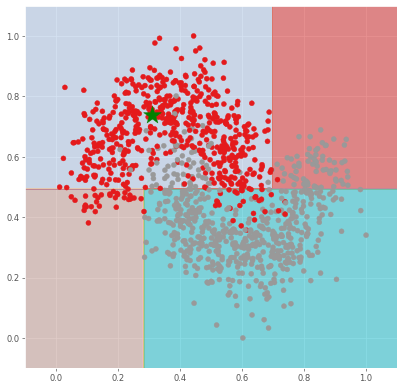

In [38]:
plt.figure(figsize=(8, 8), dpi=60)

# Compute the decision boundary of the tree
x_y_step = 0.005
x_min, x_max = -0.1, 1.1
y_min, y_max = -0.1, 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, x_y_step),
                     np.arange(y_min, y_max, x_y_step))

Z = tree_binariser_moons.apply(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
Z_norm = np.zeros_like(Z)
for i, v in enumerate(np.unique(Z)):
    mask = (Z == v)
    Z_norm[mask] = i

# Plot the boundary
plt.contourf(xx, yy, Z_norm, cmap=plt.cm.tab20, alpha=0.5)

# Plot data
plt.scatter(moons_X[:, 0], moons_X[:, 1], cmap=plt.cm.Set1, c=moons_y)

# Plot explained instance
plt.scatter(instance_m[0], instance_m[1], c='green', marker='*', s=500)

In [39]:
moons_X_binary_tree = tree_binariser_moons.apply(moons_X)

In [40]:
fatf_ecml.weighted_purity(moons_X_binary_tree, moons_y, 'gini')

0.13809164792390438

This result is on a par with the binary representation achieved with
quartile-based discretisation (0.13).


## Real Data -- Bike Sharing ##
Let's repeat the same procedure with a real-life data set.
In the example above, we generated the representations based on the **entire**
data set and used **ground truth** labels, neither of which is done when
building a *local* surrogate.
Therefore, with the Bike Sharing data set we will:

* generate a data sample around a data point chosen to be explained and
  use these data to evaluate purity of the interpretable representation; and
* evaluate purity based on predictions of a black box.

Since this data set has more than two feature, we cannot visualise the
behaviour of the interpretable representation.
Instead, we will rely on the numerical purity: Gini Index for *crisp* and
Mean Squared Error for *probabilistic* classifiers.

First, let's get the data set and build one probabilistic and one crisp
black-box model.

In [41]:
(bikes_train_X,
 bikes_test_X,
 bikes_train_y,
 bikes_test_y,
 bikes_feature_names,
 bikes_target_name) = fatf_ecml.generate_bikes(random_seed=42)

bikes_target_classes = ['low', 'medium', 'high']

20-Sep-01 16:38:19 fatf         INFO     Seeding RNGs using the input parameter.
20-Sep-01 16:38:19 fatf         INFO     Seeding RNGs with 42.


In [42]:
clf_bikes_probabilistic = fatf_ecml.get_random_forest(
    bikes_train_X, bikes_train_y, random_seed=42)

20-Sep-01 16:38:21 fatf         INFO     Seeding RNGs using the input parameter.
20-Sep-01 16:38:21 fatf         INFO     Seeding RNGs with 42.


In [43]:
clf_bikes_crisp = fatf_ecml.get_svc(
    bikes_train_X, bikes_train_y, random_seed=42)

20-Sep-01 16:38:21 fatf         INFO     Seeding RNGs using the input parameter.
20-Sep-01 16:38:21 fatf         INFO     Seeding RNGs with 42.


Now, let's select a data point to be explained and generate a sample of 10,000
instances around it (see the *Data Sampling* notebook for more details on
sampling).

We also predict the sample with both of our black boxes to get crisp
predictions and probabilities, which we use to investigate purity
of the interpretable representations.
This can serve as a proxy for how well interpretable representations capture
a black-box decision boundary, which we try to approximate with our surrogate.

In [44]:
instance_b_index = 42
instance_b = bikes_test_X[instance_b_index, :]
instance_b_label = bikes_test_y[instance_b_index]

display(instance_b)
display(instance_b_label)

array([2.      , 0.      , 6.      , 0.      , 6.      , 0.      ,
       1.      , 0.696667, 0.643954, 0.670417, 0.119408], dtype=float32)

1

In [45]:
fatf.setup_random_seed(42)

augmenter_bikes = fatf_augmentation.NormalSampling(bikes_train_X)

sample_bikes_b = augmenter_bikes.sample(
    instance_b, samples_number=10000)

20-Sep-01 16:40:20 fatf         INFO     Seeding RNGs using the input parameter.
20-Sep-01 16:40:20 fatf         INFO     Seeding RNGs with 42.


Note that for the probabilistic classifier, we only choose the probabilities
of a single class -- the one predicted by the black box for the explained
instance.

In [46]:
instance_b_prediction_proba = clf_bikes_probabilistic.predict_proba(
    [instance_b])
instance_b_prediction = int(np.argmax(instance_b_prediction_proba))
display(instance_b_prediction)

sample_bikes_b_predictions_proba = clf_bikes_probabilistic.predict_proba(
    sample_bikes_b)

sample_bikes_b_predictions_proba = (
    sample_bikes_b_predictions_proba[:, instance_b_prediction]
)

1

In [47]:
instance_b_prediction_crisp = clf_bikes_crisp.predict([instance_b])
display(instance_b_prediction_crisp[0])

sample_bikes_b_predictions_crisp = clf_bikes_crisp.predict(
    sample_bikes_b)

1

As a point of reference, let's measure the purity of the sample without either
discretisation or binarisation.
We start with the probabilistic sample.

In [48]:
fatf_ecml.mse(sample_bikes_b_predictions_proba)

0.05288705751874819

This number may be difficult to read.
Let's visualise the probability distribution of this class.

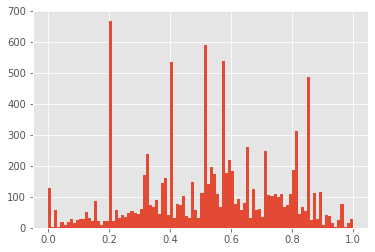

In [49]:
_ = plt.hist(sample_bikes_b_predictions_proba, bins=100)

It is quite a diverse sample, which is desirable (see the *Data Sampling*
notebook for more details).

---

Let's move on to the crisp sample.
(Recall that *Gini Impurity* for *three* classes can have the maximum value of
$\frac{2}{3}$.)

In [50]:
fatf_ecml.gini_index(sample_bikes_b_predictions_crisp)

0.5654105

The latter score is quite high.
Let's inspect the class counts.

In [51]:
np.unique(sample_bikes_b_predictions_crisp, return_counts=True)

(array([0, 1, 2]), array([4385, 4865,  750]))

Similar to probabilities, this sample is fairly diverse as well.

### Interpretable Representation Based on Quartile Discretisation ###
For quartile-based discretisation, we are facing with a choice of data to be
used for computing the quartiles.
Shall we use data from the same distribution as our entire Bikes data set,
or instead use the data sampled in the neighbourhood of the explained instance?

While you may think that the latter approach is desired, the choice is not obvious
because of the curse of dimensionality.
With 11 features and 4 bins per feature, we will be creating
$4^{11} = 4,194,304$ hyper-rectangles.
This granularity is overwhelming when compared to the number of instances
in the data set or the number of sampled data points.
With this many partitions, it may actually be better to apply discretisation
step to the entire feature space.

The next step is binarisation.
Similarly, it will give $2^{11} = 2,048$ partitions --
it is more manageable but still a lot.

Let's do both approaches -- the entire data distribution and the local sample
-- and compare the purity of each step: discretisation and binarisation.

#### Whole Data Discretisation ####
In this case the quartiles are computed based on the distribution of the
entire data set (this is how LIME operates).
To this end, we will use the *Bikes Sharing* **test** set.

In [52]:
bikes_test_q_discretiser = fatf_discretisation.QuartileDiscretiser(bikes_test_X)

In [53]:
instance_b_discrete_t = bikes_test_q_discretiser.discretise(instance_b)

In [54]:
sample_bikes_b_discrete_t = bikes_test_q_discretiser.discretise(sample_bikes_b)

In [55]:
fatf_ecml.weighted_purity(
    sample_bikes_b_discrete_t,
    sample_bikes_b_predictions_crisp,
    'gini')

0.05524230158730158

Discretisation based on quartiles that are determined by the **entire data
distribution** give a considerable reduction in impurity.
Recall that the entire sample had Gini Index of 0.565.
However, this is not the representation used for computing surrogate
explanations.
We still need to binarise this space, which, as we have seen above, is the
step that causes troubles.

In [56]:
sample_bikes_b_binary_t = fatf_transformation.dataset_row_masking(
    sample_bikes_b_discrete_t, instance_b_discrete_t)

In [57]:
fatf_ecml.weighted_purity(
    sample_bikes_b_binary_t,
    sample_bikes_b_predictions_crisp,
    'gini')

0.41021482545580185

It seems that by combining hyper-rectangles we are not too far off from
where we started.
This does not look promising for the quality of our future explanations.

---

Let's have a look at the probabilistic black box now, before we move on
to quartiles based on the sampled data.

In [58]:
fatf_ecml.weighted_purity(
    sample_bikes_b_discrete_t,
    sample_bikes_b_predictions_proba,
    'mse')

0.007986073566028934

In [59]:
fatf_ecml.weighted_purity(
    sample_bikes_b_binary_t,
    sample_bikes_b_predictions_proba,
    'mse')

0.03765456999193213

Again, we notice a similar trend.
Discretisation gives us a considerable reduction (0.008 from 0.053), followed
by a binarisation-induced increase to 0.038.

#### Sampled Data Discretisation ####
In this case, the quartiles are computed based on the distribution of the
**data sampled in the neighbourhood** of the explained instance.
Let's compute purity of this discretisation and binarisation.

In [60]:
bikes_sample_q_discretiser = fatf_discretisation.QuartileDiscretiser(
    sample_bikes_b)

In [61]:
instance_b_discrete_s = bikes_sample_q_discretiser.discretise(instance_b)

In [62]:
sample_bikes_b_discrete_s = bikes_sample_q_discretiser.discretise(
    sample_bikes_b)

In [63]:
fatf_ecml.weighted_purity(
    sample_bikes_b_discrete_s,
    sample_bikes_b_predictions_crisp,
    'gini')

0.0005

In [64]:
sample_bikes_b_binary_s = fatf_transformation.dataset_row_masking(
    sample_bikes_b_discrete_s, instance_b_discrete_s)

In [65]:
fatf_ecml.weighted_purity(
    sample_bikes_b_binary_s,
    sample_bikes_b_predictions_crisp,
    'gini')

0.4294403699716251

In this case the discretisation purity is nearly perfect.
However, it should not come as a surprise.
With 4,194,304 hyper-rectangles and just 10,000 data points points, each one
can be assigned to a separate partition.
When compared to the quartiles computed with the entire data set, local
partition is simply **overfitted**.
We can observe this lack of generalisation when moving from the discrete into
the binary representation, which has considerable impurity of 0.429.

We can validate our theory by inspecting counts.

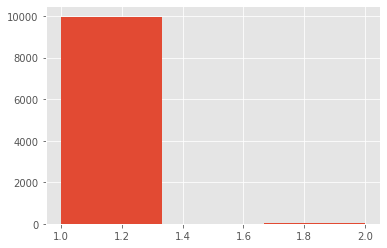

In [66]:
_, counts = np.unique(sample_bikes_b_discrete_s, return_counts=True, axis=0)
_ = plt.hist(counts, bins=3)

The vast majority of hyper-rectangles enclose just a *single* data point.

---

Let's check purity for the probabilistic model.
We should observe a similar behaviour.

In [67]:
fatf_ecml.weighted_purity(
    sample_bikes_b_discrete_s,
    sample_bikes_b_predictions_proba,
    'mse')

3.746483187175399e-05

In [68]:
fatf_ecml.weighted_purity(
    sample_bikes_b_binary_s,
    sample_bikes_b_predictions_proba,
    'mse')

0.04412780561123212

As expected, we observe a reduction of the Mean Squared Error to 0.000037
for discretisation and increase to 0.044 for binarisation (the overall purity
is 0.053).

### Interpretable Representation Based on a Decision Tree ###
For tree-based interpretable representations it is only reasonable to
fit the tree to the local sample.
Otherwise, we would be competing with the black box, which is not
any different from actually using a decision tree to model the entire
data in a more transparent way.
(And the black box was chosen for a reason...)

There are two possible approaches to ensure comparability with the
quartile-based interpretable representation.
One is to limit the number of tree leaves to $2^{11} = 2,048$, which
corresponds to the number of unique representations in the binarised
quartile-based representation.
Alternatively, if we choose to one-hot-encode the tree partitions, we
should limit the number of leaves to 11.

Let's see how both of these scenarios play out.

In [69]:
tree_bikes_crisp_2048 = sklearn.tree.DecisionTreeClassifier(
    random_state=42, max_leaf_nodes=2048)
tree_bikes_crisp_2048.fit(sample_bikes_b, sample_bikes_b_predictions_crisp)

DecisionTreeClassifier(max_leaf_nodes=2048, random_state=42)

In [70]:
sample_bikes_b_tree_crisp_2048 = tree_bikes_crisp_2048.apply(sample_bikes_b)

In [71]:
fatf_ecml.weighted_purity(
    sample_bikes_b_tree_crisp_2048,
    sample_bikes_b_predictions_crisp,
    'gini')

0.0

In [72]:
unique = np.unique(sample_bikes_b_tree_crisp_2048)
print('Leaves #: {}.'.format(unique.shape[0]))

Leaves #: 577.


Therefore, with "just" 577 partitions we can reduce the impurity to 0,
compared to the original impurity of 0.565 and best quartile-based binarised
score of 0.410.

Let's see how we will do with just 11 leaves.

In [73]:
tree_bikes_crisp_11 = sklearn.tree.DecisionTreeClassifier(
    random_state=42, max_leaf_nodes=11)
tree_bikes_crisp_11.fit(sample_bikes_b, sample_bikes_b_predictions_crisp)

DecisionTreeClassifier(max_leaf_nodes=11, random_state=42)

In [74]:
sample_bikes_b_tree_crisp_11 = tree_bikes_crisp_11.apply(sample_bikes_b)

In [75]:
fatf_ecml.weighted_purity(
    sample_bikes_b_tree_crisp_11,
    sample_bikes_b_predictions_crisp,
    'gini')

0.2340876374955482

Not too bad.
We managed to reduce the impurity 2.5 times with just 11 leaves.

---

Let's execute the same experiments for the probabilistic model.

In [76]:
tree_bikes_proba_2048 = sklearn.tree.DecisionTreeRegressor(
    random_state=42, max_leaf_nodes=2048)
tree_bikes_proba_2048.fit(sample_bikes_b, sample_bikes_b_predictions_proba)

DecisionTreeRegressor(max_leaf_nodes=2048, random_state=42)

In [77]:
sample_bikes_b_tree_proba_2048 = tree_bikes_proba_2048.apply(sample_bikes_b)

In [78]:
fatf_ecml.weighted_purity(
    sample_bikes_b_tree_proba_2048,
    sample_bikes_b_predictions_proba,
    'mse')

2.905806140202128e-05

In [79]:
unique = np.unique(sample_bikes_b_tree_proba_2048)
print('Leaves #: {}.'.format(unique.shape[0]))

Leaves #: 2048.


In [80]:
tree_bikes_proba_11 = sklearn.tree.DecisionTreeRegressor(
    random_state=42, max_leaf_nodes=11)
tree_bikes_proba_11.fit(sample_bikes_b, sample_bikes_b_predictions_proba)

DecisionTreeRegressor(max_leaf_nodes=11, random_state=42)

In [81]:
sample_bikes_b_tree_proba_11 = tree_bikes_proba_11.apply(sample_bikes_b)

In [82]:
fatf_ecml.weighted_purity(
    sample_bikes_b_tree_proba_11,
    sample_bikes_b_predictions_proba,
    'mse')

0.026033229911113745

In case of the probabilistic model, we can reduce the MSE to 0.000029 with
the full expressiveness of 2,048 partitions, which increases to 0.026
with just 11 partitions -- recall that the whole sample has the Mean Squared
Error of 0.053.

## Summary ##
This notebook showed two distinct approaches to generating interpretable
representations of tabular data and variants thereof.
It is worth noting that these insights should **not** be generalised to other
data sets and use cases.
Instead, a similar **exploratory** procedure should be employed, with various approaches
analysed to choose the most suitable interpretable representation for the
problem at hand.

> In summary, the core premise of analysing purity (or uniformity) of **black-box
  predictions** when distributed across **partitions** of a tabular interpretable
  representation is to ensure that our hyper-rectangles **align** with black-box
  decision boundaries in the modelled neighbourhood.
  If such a partition is pure, the decision boundary coincides with our feature space
  separation, hence our approximation is faithful.
  If a black-box decision boundary runs across a hyper-rectangle, on the other hand,
  its purity score should reflect it.

---

Now, let's move on to *sampling* data in the neighbourhood of the explained
instance, which is the next step of building local surrogate explainers.
